In [6]:
'''This script tunes the L2 reg weight of the final classifier.'''
import argparse
import os
import math

import torch
import torch.backends.cudnn as cudnn

from configs import get_datasets
from evaluate import encode_train_set, train_clf, test
from models import *
from tqdm import tqdm
import numpy as np

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
def test_topk(testloader, device, net, clf, k):
    criterion = nn.CrossEntropyLoss()
    net.eval()
    clf.eval()
    test_clf_loss = 0
    correct = 0
    total = 0
    topk_acc = np.zeros(k)
    with torch.no_grad():
        t = tqdm(enumerate(testloader), total=len(testloader), desc='Loss: **** | Test Acc: ****% ',
                 bar_format='{desc}{bar}{r_bar}')
        for batch_idx, (inputs, targets) in t:
            inputs, targets = inputs.to(device), targets.to(device)
            representation = net(inputs)
            # test_repr_loss = criterion(representation, targets)
            raw_scores = clf(representation)
            clf_loss = criterion(raw_scores, targets)

            test_clf_loss += clf_loss.item()
            _, predicted = raw_scores.topk(k, 1, True, True)
            total += targets.size(0)
            correct += predicted.eq(targets.unsqueeze(-1).expand_as(predicted)).sum().item()
            
            
            correct_ = predicted.eq(targets.unsqueeze(-1).expand_as(predicted))
            for i in range(1,k+1):
                topk_acc[i-1] += correct_[:,:i].sum().item()

            t.set_description('Loss: %.3f | Test Acc: %.3f%% ' % (test_clf_loss / (batch_idx + 1), 100. * correct / total))
    topk_acc = 100.* topk_acc/ total
    acc = 100. * correct / total
    return topk_acc, test_clf_loss / len(testloader)
#     return raw_scores, targets

In [9]:
def cal_topk_accuracy(file, k):
    load_from = file
    num_workers = 2
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dataset = 'cifar10'
    arch = 'resnet18'

    print('==> Preparing data..')
    _, testset, clftrainset, num_classes, stem = get_datasets(dataset)

    testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                             pin_memory=True)
    clftrainloader = torch.utils.data.DataLoader(clftrainset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                                 pin_memory=True)

    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    resume_from = os.path.join('./checkpoint', load_from)
    checkpoint = torch.load(resume_from)
    
    if arch == 'resnet18':
        net = ResNet18(stem=stem)
    elif arch == 'resnet34':
        net = ResNet34(stem=stem)
    elif archh == 'resnet50':
        net = ResNet50(stem=stem)
    else:
        raise ValueError("Bad architecture specification")
    net = net.to(device)

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    print('==> Loading encoder from checkpoint..')
    net.load_state_dict(checkpoint['net'])
    
    best_acc = 0
    X, y = encode_train_set(clftrainloader, device, net)
    clf = train_clf(X, y, net.representation_dim, num_classes, device, reg_weight=1e-5)
    
    ##### test #####
    acc,test_loss = test_topk(testloader, device, net, clf, k)
    
    return acc, test_loss

In [10]:
cal_topk_accuracy('inv-gp-0_run2_epoch199.pth', 5)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Loading encoder from checkpoint..


Encoded 49/50: ██████████| 50/50 [00:07<00:00,  6.85it/s]
Loss: 0.488 | Train Acc: 82.762% :           | 0/500 [00:00<?, ?it/s]


L2 Regularization weight: 1e-05


Loss: 0.329 | Train Acc: 88.492% : ██████████| 500/500 [00:15<00:00, 32.85it/s] 
Loss: 0.428 | Test Acc: 99.500% : ██████████| 10/10 [00:01<00:00,  5.66it/s]


(array([84.9 , 94.43, 97.39, 98.85, 99.5 ]), 0.4278107464313507)

In [11]:
cal_topk_accuracy('inv-gp-1_norm_run2_epoch199.pth', 5)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Loading encoder from checkpoint..


Encoded 49/50: ██████████| 50/50 [00:07<00:00,  6.86it/s]
Loss: 0.726 | Train Acc: 75.288% :           | 0/500 [00:00<?, ?it/s]


L2 Regularization weight: 1e-05


Loss: 0.326 | Train Acc: 88.744% : ██████████| 500/500 [01:23<00:00,  5.98it/s]
Loss: 0.405 | Test Acc: 99.600% : ██████████| 10/10 [00:01<00:00,  5.56it/s]


(array([85.81, 94.78, 97.75, 99.12, 99.6 ]), 0.4046896308660507)

In [12]:
base_topk_acc = []
for file in ['inv-gp-0_run1_epoch199.pth','inv-gp-0_run2_epoch199.pth','inv-gp-0_run3_epoch199.pth','inv-gp-0_run4_epoch199.pth','inv-gp-0_run5_epoch199.pth']:
    acc, test_loss = cal_topk_accuracy(file, 5)
    base_topk_acc.append(acc)
base_topk_acc = np.stack(base_topk_acc)


gp_topk_acc = []
for file in  ['inv-gp-1_norm_run1_epoch199.pth','inv-gp-1_norm_run2_epoch199.pth','inv-gp-1_norm_run3_epoch199.pth', 'inv-gp-1_norm_run4_epoch199.pth','inv-gp-1_norm_run5_epoch199.pth']:
    acc, test_loss = cal_topk_accuracy(file, 5)
    gp_topk_acc.append(acc)
gp_topk_acc = np.stack(gp_topk_acc)


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Loading encoder from checkpoint..


Encoded 49/50: ██████████| 50/50 [00:07<00:00,  6.91it/s]
Loss: 0.462 | Train Acc: 83.598% :           | 0/500 [00:00<?, ?it/s]


L2 Regularization weight: 1e-05


Loss: 0.323 | Train Acc: 88.774% : ██████████| 500/500 [00:17<00:00, 28.71it/s] 
Loss: 0.434 | Test Acc: 99.440% : ██████████| 10/10 [00:01<00:00,  5.67it/s]


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Loading encoder from checkpoint..


Encoded 49/50: ██████████| 50/50 [00:07<00:00,  6.86it/s]
Loss: 0.488 | Train Acc: 82.840% :           | 0/500 [00:00<?, ?it/s]


L2 Regularization weight: 1e-05


Loss: 0.329 | Train Acc: 88.498% : ██████████| 500/500 [00:16<00:00, 30.33it/s] 
Loss: 0.428 | Test Acc: 99.500% : ██████████| 10/10 [00:01<00:00,  5.53it/s]


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Loading encoder from checkpoint..


Encoded 49/50: ██████████| 50/50 [00:07<00:00,  6.80it/s]
Loss: 0.437 | Train Acc: 84.496% :           | 1/500 [00:00<01:10,  7.05it/s]


L2 Regularization weight: 1e-05


Loss: 0.319 | Train Acc: 88.892% : ██████████| 500/500 [00:15<00:00, 32.18it/s] 
Loss: 0.422 | Test Acc: 99.480% : ██████████| 10/10 [00:01<00:00,  5.64it/s]


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Loading encoder from checkpoint..


Encoded 49/50: ██████████| 50/50 [00:07<00:00,  6.90it/s]
Loss: 0.445 | Train Acc: 84.384% :           | 0/500 [00:00<?, ?it/s]


L2 Regularization weight: 1e-05


Loss: 0.320 | Train Acc: 88.978% : ██████████| 500/500 [00:15<00:00, 32.84it/s] 
Loss: 0.421 | Test Acc: 99.420% : ██████████| 10/10 [00:01<00:00,  5.52it/s]


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Loading encoder from checkpoint..


Encoded 49/50: ██████████| 50/50 [00:07<00:00,  6.91it/s]
Loss: 0.459 | Train Acc: 83.924% :           | 0/500 [00:00<?, ?it/s]


L2 Regularization weight: 1e-05


Loss: 0.316 | Train Acc: 88.990% : ██████████| 500/500 [00:15<00:00, 32.18it/s] 
Loss: 0.424 | Test Acc: 99.460% : ██████████| 10/10 [00:01<00:00,  5.50it/s]


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Loading encoder from checkpoint..


Encoded 49/50: ██████████| 50/50 [00:07<00:00,  6.88it/s]
Loss: 0.744 | Train Acc: 74.342% :           | 0/500 [00:00<?, ?it/s]


L2 Regularization weight: 1e-05


Loss: 0.335 | Train Acc: 88.692% : ██████████| 500/500 [01:35<00:00,  5.26it/s]
Loss: 0.413 | Test Acc: 99.500% : ██████████| 10/10 [00:01<00:00,  5.51it/s]


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Loading encoder from checkpoint..


Encoded 49/50: ██████████| 50/50 [00:07<00:00,  6.85it/s]
Loss: 0.753 | Train Acc: 74.572% :           | 0/500 [00:00<?, ?it/s]


L2 Regularization weight: 1e-05


Loss: 0.326 | Train Acc: 88.740% : ██████████| 500/500 [01:31<00:00,  5.48it/s]
Loss: 0.405 | Test Acc: 99.600% : ██████████| 10/10 [00:01<00:00,  5.48it/s]


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Loading encoder from checkpoint..


Encoded 49/50: ██████████| 50/50 [00:07<00:00,  6.82it/s]
Loss: 0.778 | Train Acc: 73.736% :           | 0/500 [00:00<?, ?it/s]


L2 Regularization weight: 1e-05


Loss: 0.335 | Train Acc: 88.516% : ██████████| 500/500 [01:28<00:00,  5.63it/s]
Loss: 0.423 | Test Acc: 99.560% : ██████████| 10/10 [00:01<00:00,  5.73it/s]


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Loading encoder from checkpoint..


Encoded 49/50: ██████████| 50/50 [00:07<00:00,  6.83it/s]
Loss: 0.753 | Train Acc: 74.006% :           | 0/500 [00:00<?, ?it/s]


L2 Regularization weight: 1e-05


Loss: 0.338 | Train Acc: 88.562% : ██████████| 500/500 [01:36<00:00,  5.20it/s]
Loss: 0.424 | Test Acc: 99.570% : ██████████| 10/10 [00:01<00:00,  5.76it/s]


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Loading encoder from checkpoint..


Encoded 49/50: ██████████| 50/50 [00:07<00:00,  6.87it/s]
Loss: 0.741 | Train Acc: 74.860% :           | 0/500 [00:00<?, ?it/s]


L2 Regularization weight: 1e-05


Loss: 0.333 | Train Acc: 88.534% : ██████████| 500/500 [01:49<00:00,  4.57it/s]
Loss: 0.416 | Test Acc: 99.470% : ██████████| 10/10 [00:01<00:00,  5.77it/s]


In [13]:
base_topk_acc

array([[85.18, 94.27, 97.28, 98.69, 99.44],
       [84.91, 94.43, 97.37, 98.84, 99.5 ],
       [85.43, 94.7 , 97.38, 99.  , 99.48],
       [85.79, 94.63, 97.51, 98.9 , 99.42],
       [85.5 , 94.64, 97.51, 98.84, 99.46]])

In [35]:
print(base_topk_acc.mean(axis = 0))
print(base_topk_acc.std(axis = 0)/np.sqrt(5))

[85.362 94.534 97.41  98.854 99.46 ]
[0.13330866 0.07169937 0.03969887 0.0450422  0.01264911]


In [34]:
print(gp_topk_acc.mean(axis = 0))
print(gp_topk_acc.std(axis = 0)/np.sqrt(5))

[85.466 94.782 97.664 98.972 99.54 ]
[0.14842102 0.08155489 0.07405944 0.04265208 0.02135416]


In [14]:
gp_topk_acc

array([[85.82, 94.89, 97.93, 99.02, 99.5 ],
       [85.8 , 94.79, 97.74, 99.12, 99.6 ],
       [84.99, 94.69, 97.49, 98.97, 99.56],
       [85.18, 94.5 , 97.49, 98.91, 99.57],
       [85.54, 95.04, 97.67, 98.84, 99.47]])

In [20]:
gp_topk_acc.mean(axis = 0)

array([85.466, 94.782, 97.664, 98.972, 99.54 ])

In [15]:
import matplotlib.pyplot as plt

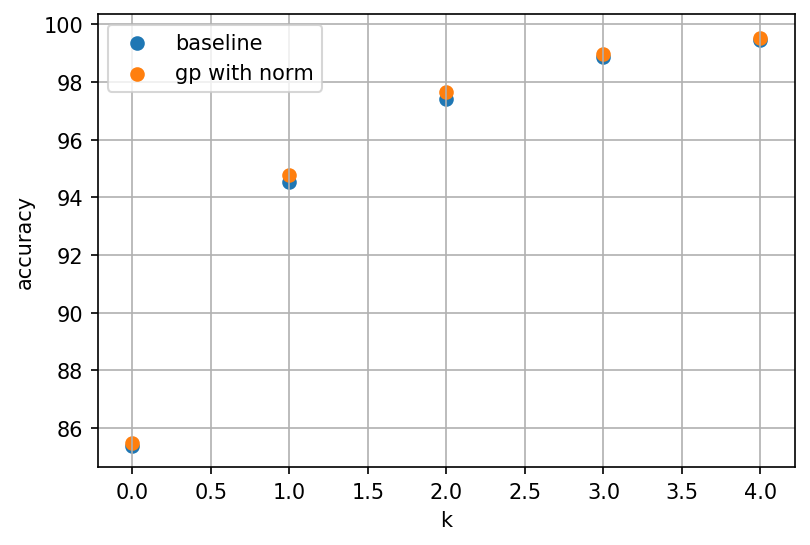

In [32]:
plt.figure( dpi = 150)
plt.scatter([i for i in range(5)], base_topk_acc.mean(axis = 0), label = 'baseline')
plt.scatter([i for i in range(5)], gp_topk_acc.mean(axis = 0), label = 'gp with norm')
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.grid(True)

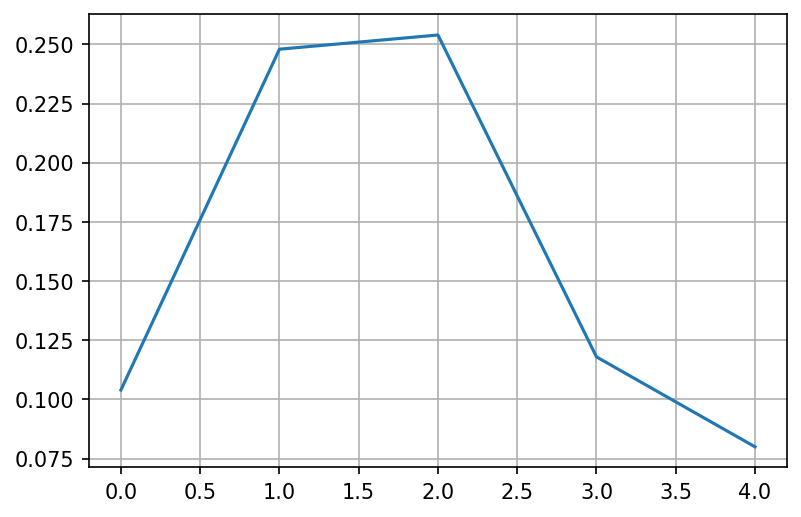

In [33]:
plt.figure( dpi = 150)
plt.plot(gp_topk_acc.mean(axis = 0) - base_topk_acc.mean(axis = 0))
plt.grid(True)